#  Heart rhythm classification from raw ECG signals

## Table of contents


- 1.0 Compare Neurokit2 default processing with custom processing
- 2.0 Extract features from heartbeat templates
- 3.0 Extract features from delineation
- 4.0 Extract HRV features
- 5.0 Define customised transformers for Pipeline


## Notes
Interesting insights from Nature paper published on 21.9.2021
- https://www.nature.com/articles/s41598-021-97118-5?proof=t%3B#Tab6
- https://www.youtube.com/watch?v=3tfin4sSBFQ
- Focus on only two features PR and RT.
- MLP and SVM


In [1]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import biosppy.signals.ecg as ecg
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
import seaborn as sns
import matplotlib.pyplot as plt
sns.set('talk')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

## Params

In [20]:
sr = 300 #sampling rate

# sampling rate needs adjustment if downsampling is applied
down_factor = 2
sr_down = sr/down_factor

# Some matplotlib setting 
plt.rcParams['figure.figsize'] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
#plt.rcParams['axes.labelsize'] = 48
#plt.rcParams['axes.titlesize'] = 48

## Read data

In [3]:
path = '/home/rapwag01/eth/aml/task2/'

In [4]:
df_train = pd.read_csv(path+'X_train.csv')

In [5]:
df_test = pd.read_csv(path+'X_test.csv')

In [6]:
df_target = pd.read_csv(path+'y_train.csv')

In [7]:
df_train.head()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178,x179,x180,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199,x200,x201,x202,x203,x204,x205,x206,x207,x208,x209,x210,x211,x212,x213,x214,x215,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225,x226,x227,x228,x229,x230,x231,x232,x233,x234,x235,x236,x237,x238,x239,x240,x241,x242,x243,x244,x245,x246,x247,x248,...,x17592,x17593,x17594,x17595,x17596,x17597,x17598,x17599,x17600,x17601,x17602,x17603,x17604,x17605,x17606,x17607,x17608,x17609,x17610,x17611,x17612,x17613,x17614,x17615,x17616,x17617,x17618,x17619,x17620,x17621,x17622,x17623,x17624,x17625,x17626,x17627,x17628,x17629,x17630,x17631,x17632,x17633,x17634,x17635,x17636,x17637,x17638,x17639,x17640,x17641,x17642,x17643,x17644,x17645,x17646,x17647,x17648,x17649,x17650,x17651,x17652,x17653,x17654,x17655,x17656,x17657,x17658,x17659,x17660,x17661,x17662,x17663,x17664,x17665,x17666,x17667,x17668,x17669,x17670,x17671,x17672,x17673,x17674,x17675,x17676,x17677,x17678,x17679,x17680,x17681,x17682,x17683,x17684,x17685,x17686,x17687,x17688,x17689,x17690,x17691,x17692,x17693,x17694,x17695,x17696,x17697,x17698,x17699,x17700,x17701,x17702,x17703,x17704,x17705,x17706,x17707,x17708,x17709,x17710,x17711,x17712,x17713,x17714,x17715,x17716,x17717,x17718,x17719,x17720,x17721,x17722,x17723,x17724,x17725,x17726,x17727,x17728,x17729,x17730,x17731,x17732,x17733,x17734,x17735,x17736,x17737,x17738,x17739,x17740,x17741,x17742,x17743,x17744,x17745,x17746,x17747,x17748,x17749,x17750,x17751,x17752,x17753,x17754,x17755,x17756,x17757,x17758,x17759,x17760,x17761,x17762,x17763,x17764,x17765,x17766,x17767,x17768,x17769,x17770,x17771,x17772,x17773,x17774,x17775,x17776,x17777,x17778,x17779,x17780,x17781,x17782,x17783,x17784,x17785,x17786,x17787,x17788,x17789,x17790,x17791,x17792,x17793,x17794,x17795,x17796,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806,x17807,x17808,x17809,x17810,x17811,x17812,x17813,x17814,x17815,x17816,x17817,x17818,x17819,x17820,x17821,x17822,x17823,x17824,x17825,x17826,x17827,x17828,x17829,x17830,x17831,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
0,0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,-70,-51,-21,34,112,227,360,450,481,452,362,228,108,25,-1,-8,-12,-14,-17,-21,-28,-35,-42,-50,-57,-67,-76,-80,-81,-82,-82,-82,-82,-82,-83,-84,-84,-83,-79,-74,-70,-66,-62,-59,-55,-51,-47,-43,-41,-39,-37,-36,-34,-33,-32,-30,-29,-26,-23,-20,-16,-13,-9,-6,-4,0,2,6,12,23,35,48,59,68,76,85,94,102,109,115,122,129,135,142,150,162,180,192,204,215,225,233,239,242,242,235,225,208,187,168,147,125,98,73,54,39,27,19,11,3,-3,-7,-9,-12,-14,-17,-19,-22,-24,-26,-28,-30,-32,-34,-35,-36,-39,-45,-51,-51,-46,-39,-30,-20,-16,-14,-14,-13,-12,-11,-10,-9,-9,-8,-7,-6,-5,-4,-3,-2,0,3,12,29,52,88,135,189,243,296,334,348,353,349,340,331,322,312,300,266,203,138,88,51,13,-3,-10,-13,-16,-17,-18,-17,-15,-11,-6,-1,5,15,22,28,33,37,40,41,37,29,20,13,6,0,-4,-7,-6,-3,2,9,22,45,68,93,121,149,174,189,192,193,195,196,196,196,195,192,187,181,170,149,129,106,77,51,14,-27,-49,-63,-72,-80,-88,-97,-105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [22]:
## Get one sample per class, taken from biosppy_examples.ipynb
labels_array = df_target['y'].to_numpy()
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[0]))
    
# Print indices of the sample signals
sample_signal_ids

[0, 3, 4, 30]

In [9]:
## Compare default processing with

## 1.0 Compare default preprocessing by NeuroKit2 to custom processing
Plot results for each class using only one example sample

### 1.1 Default

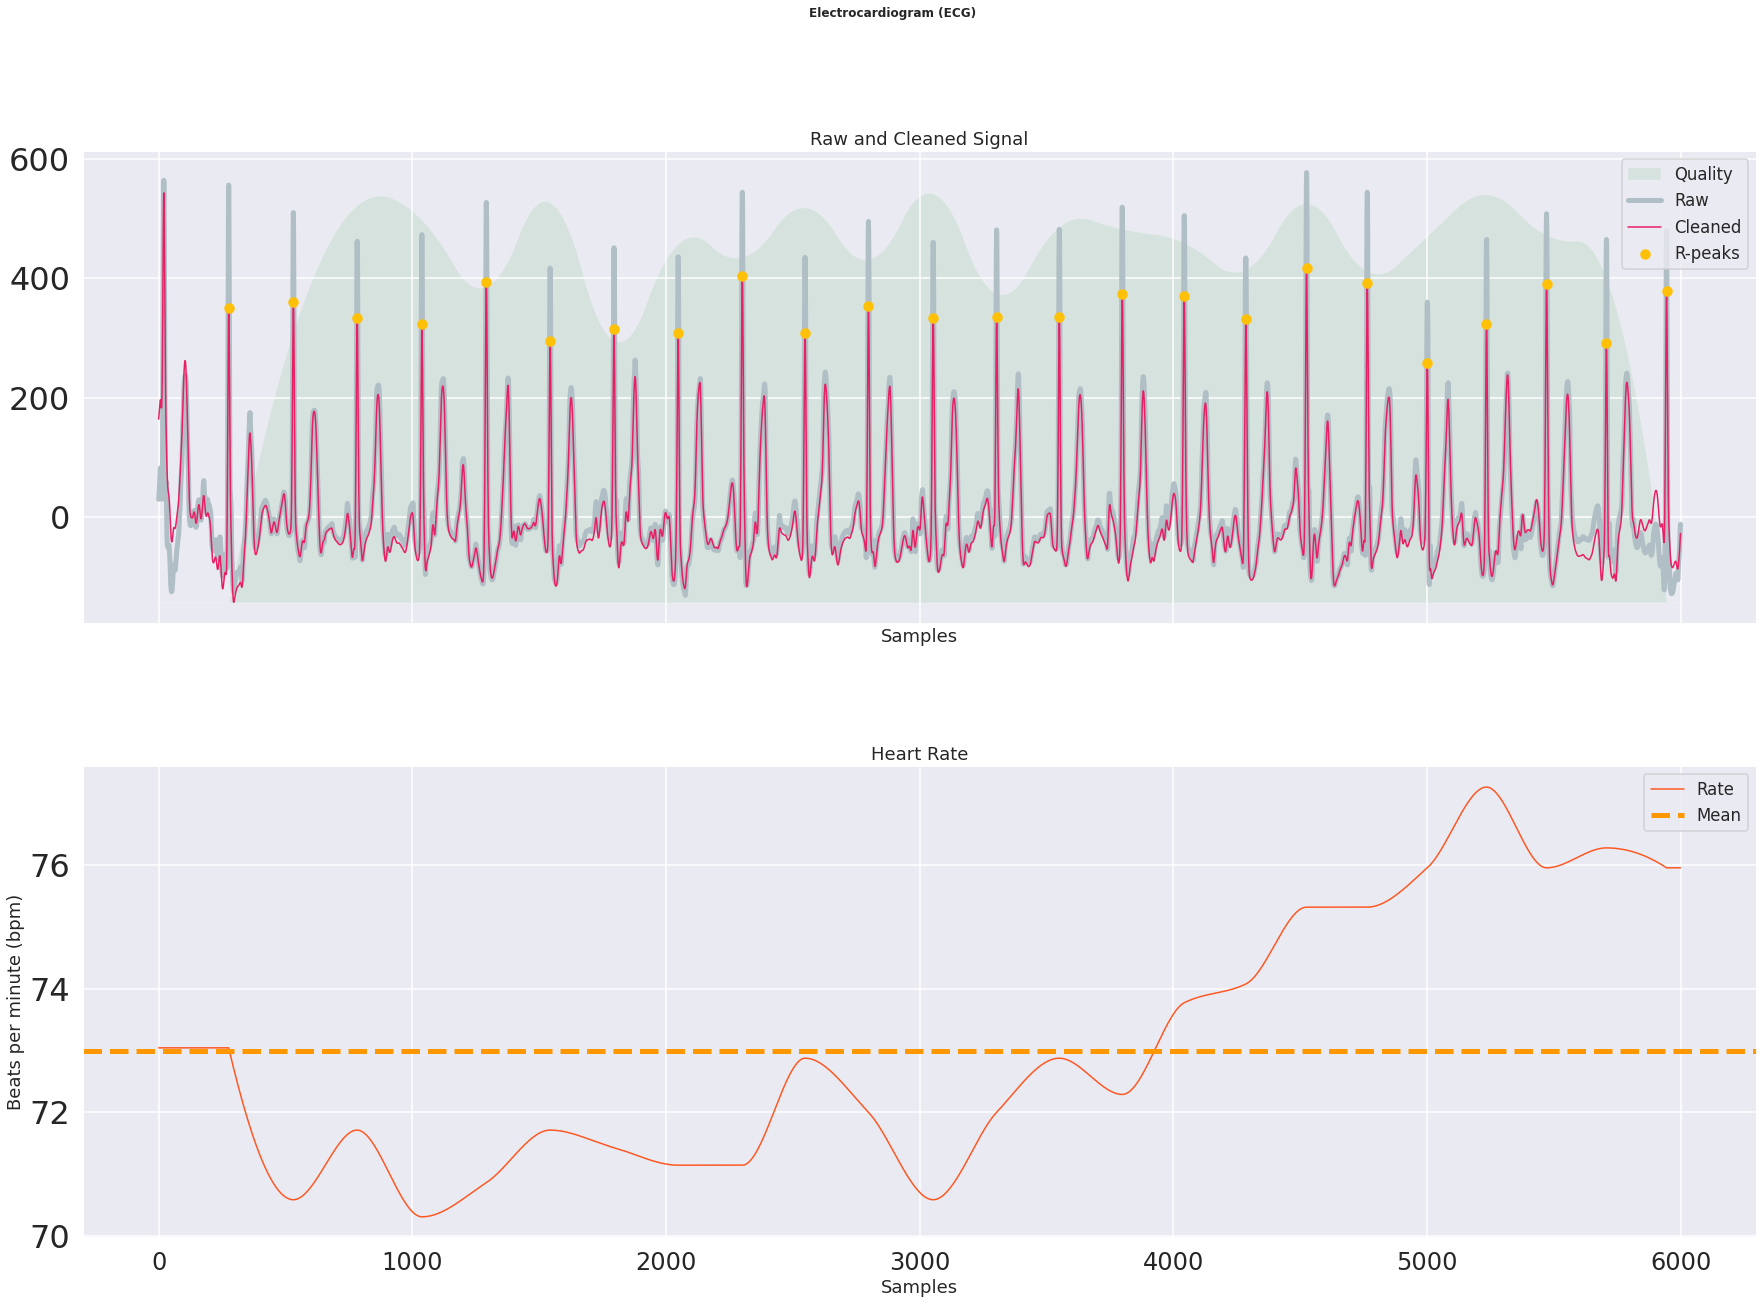

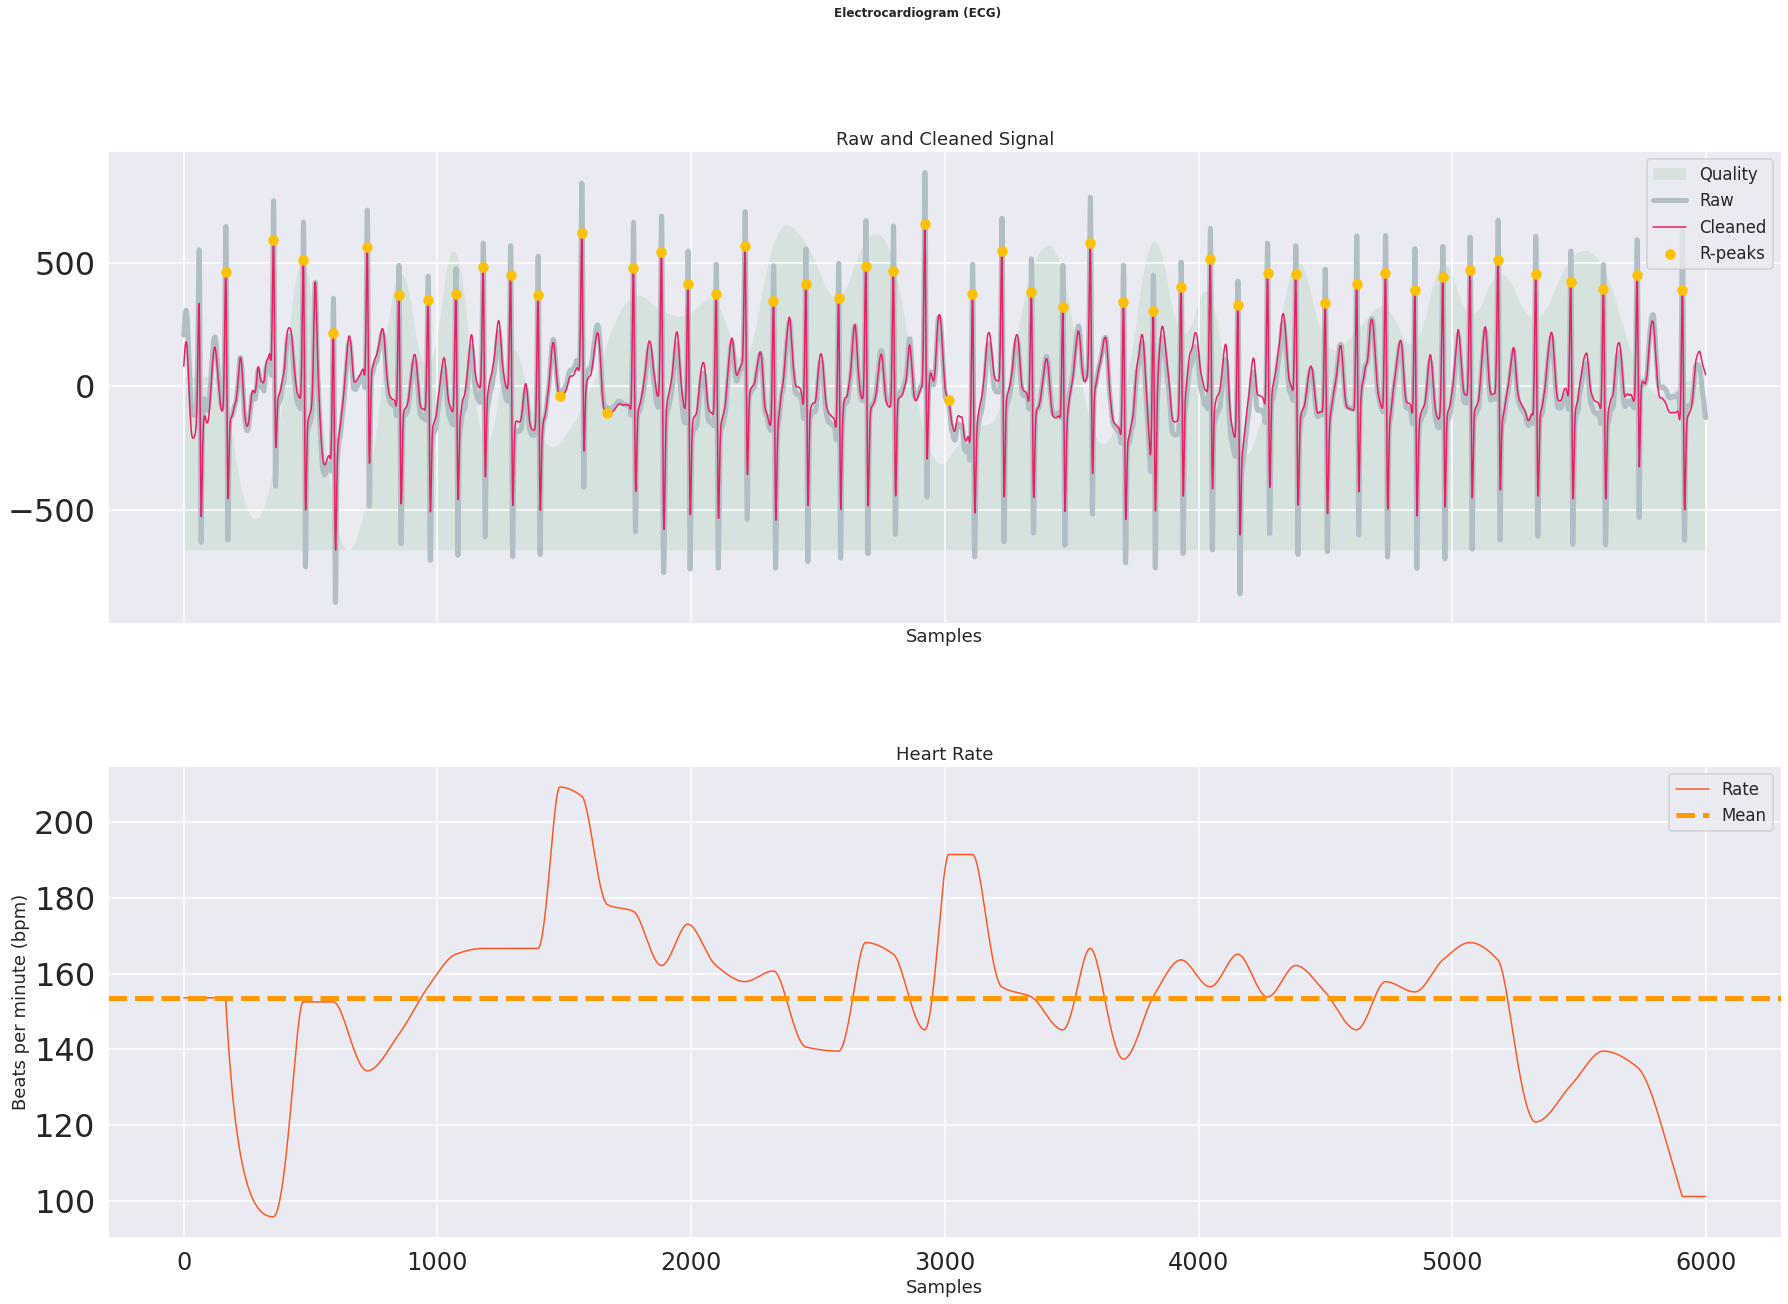

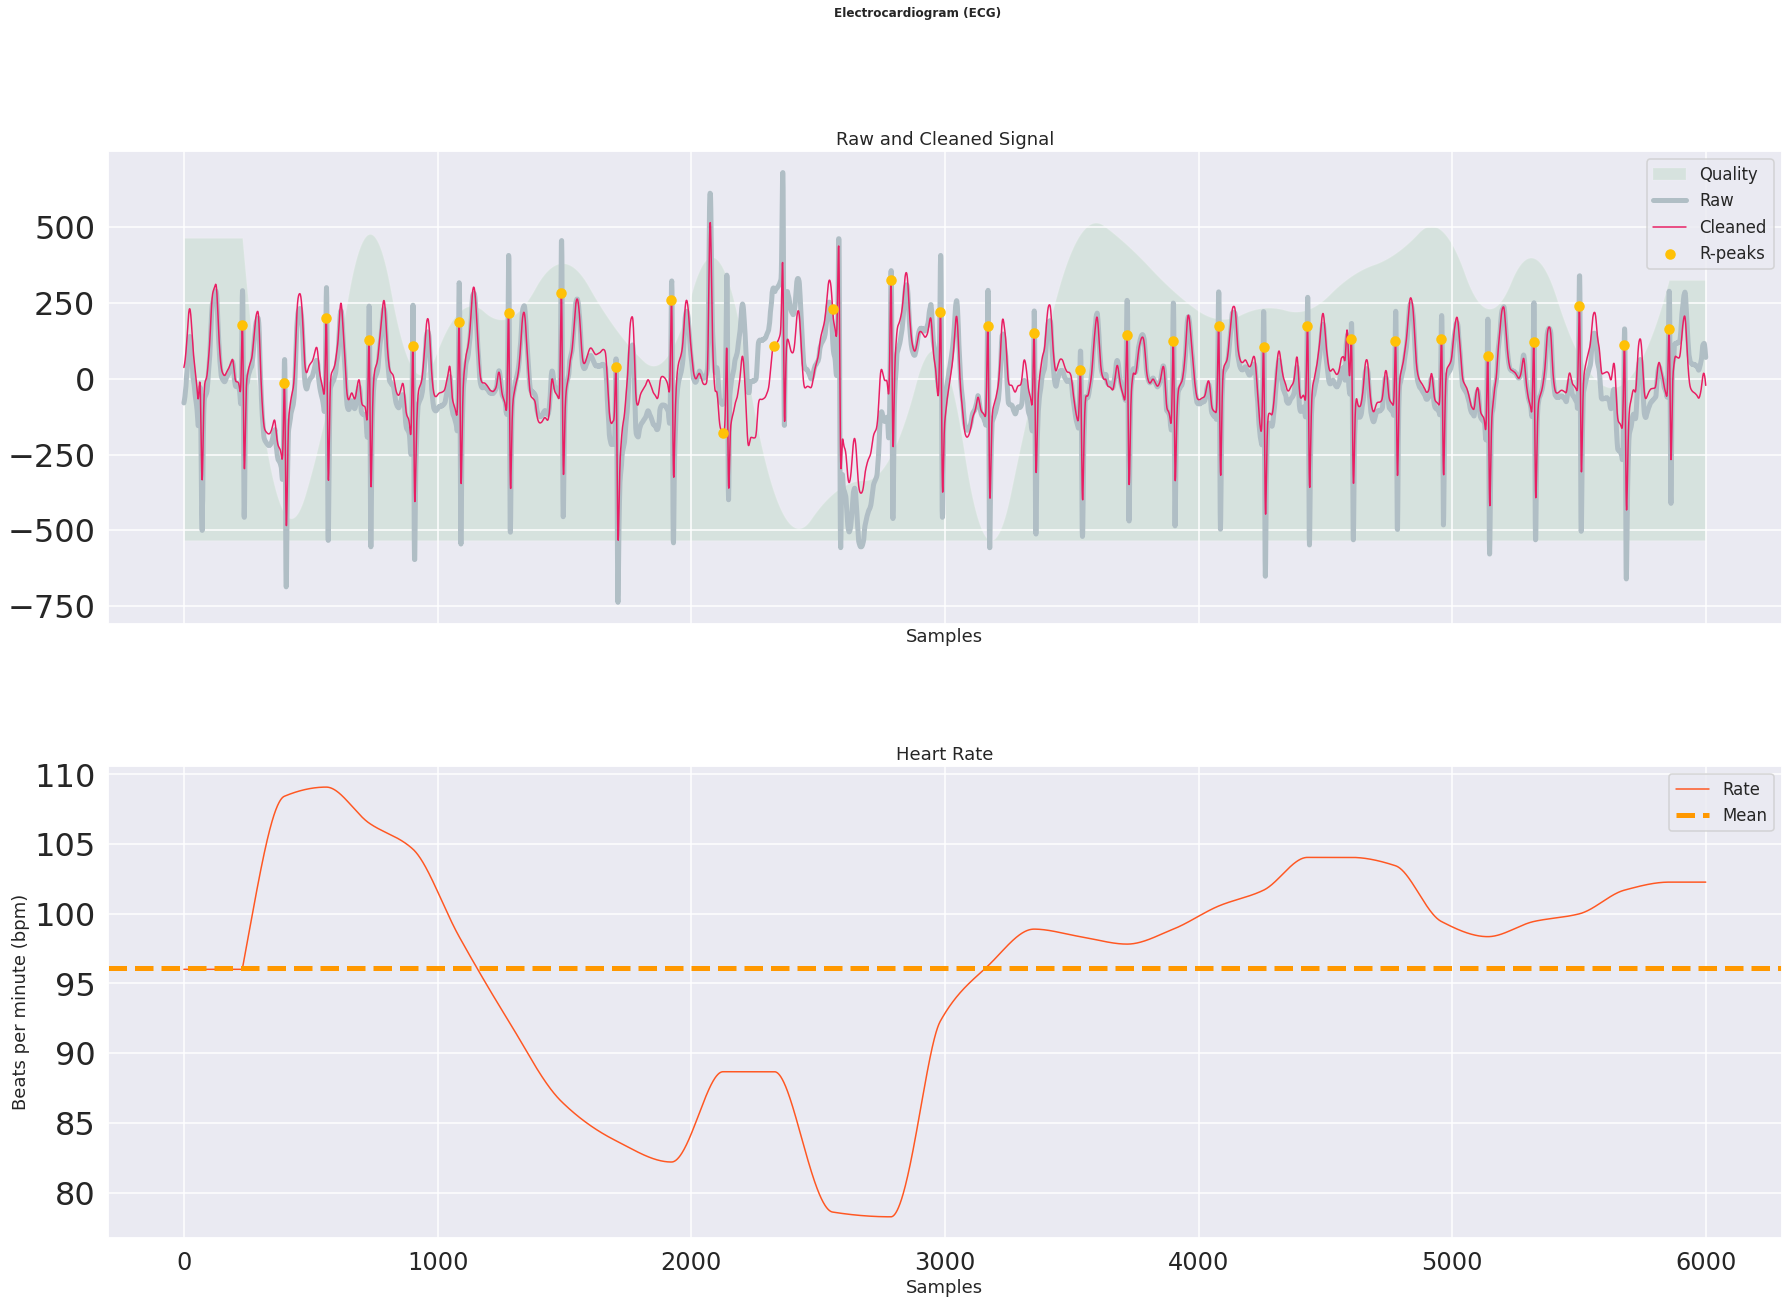

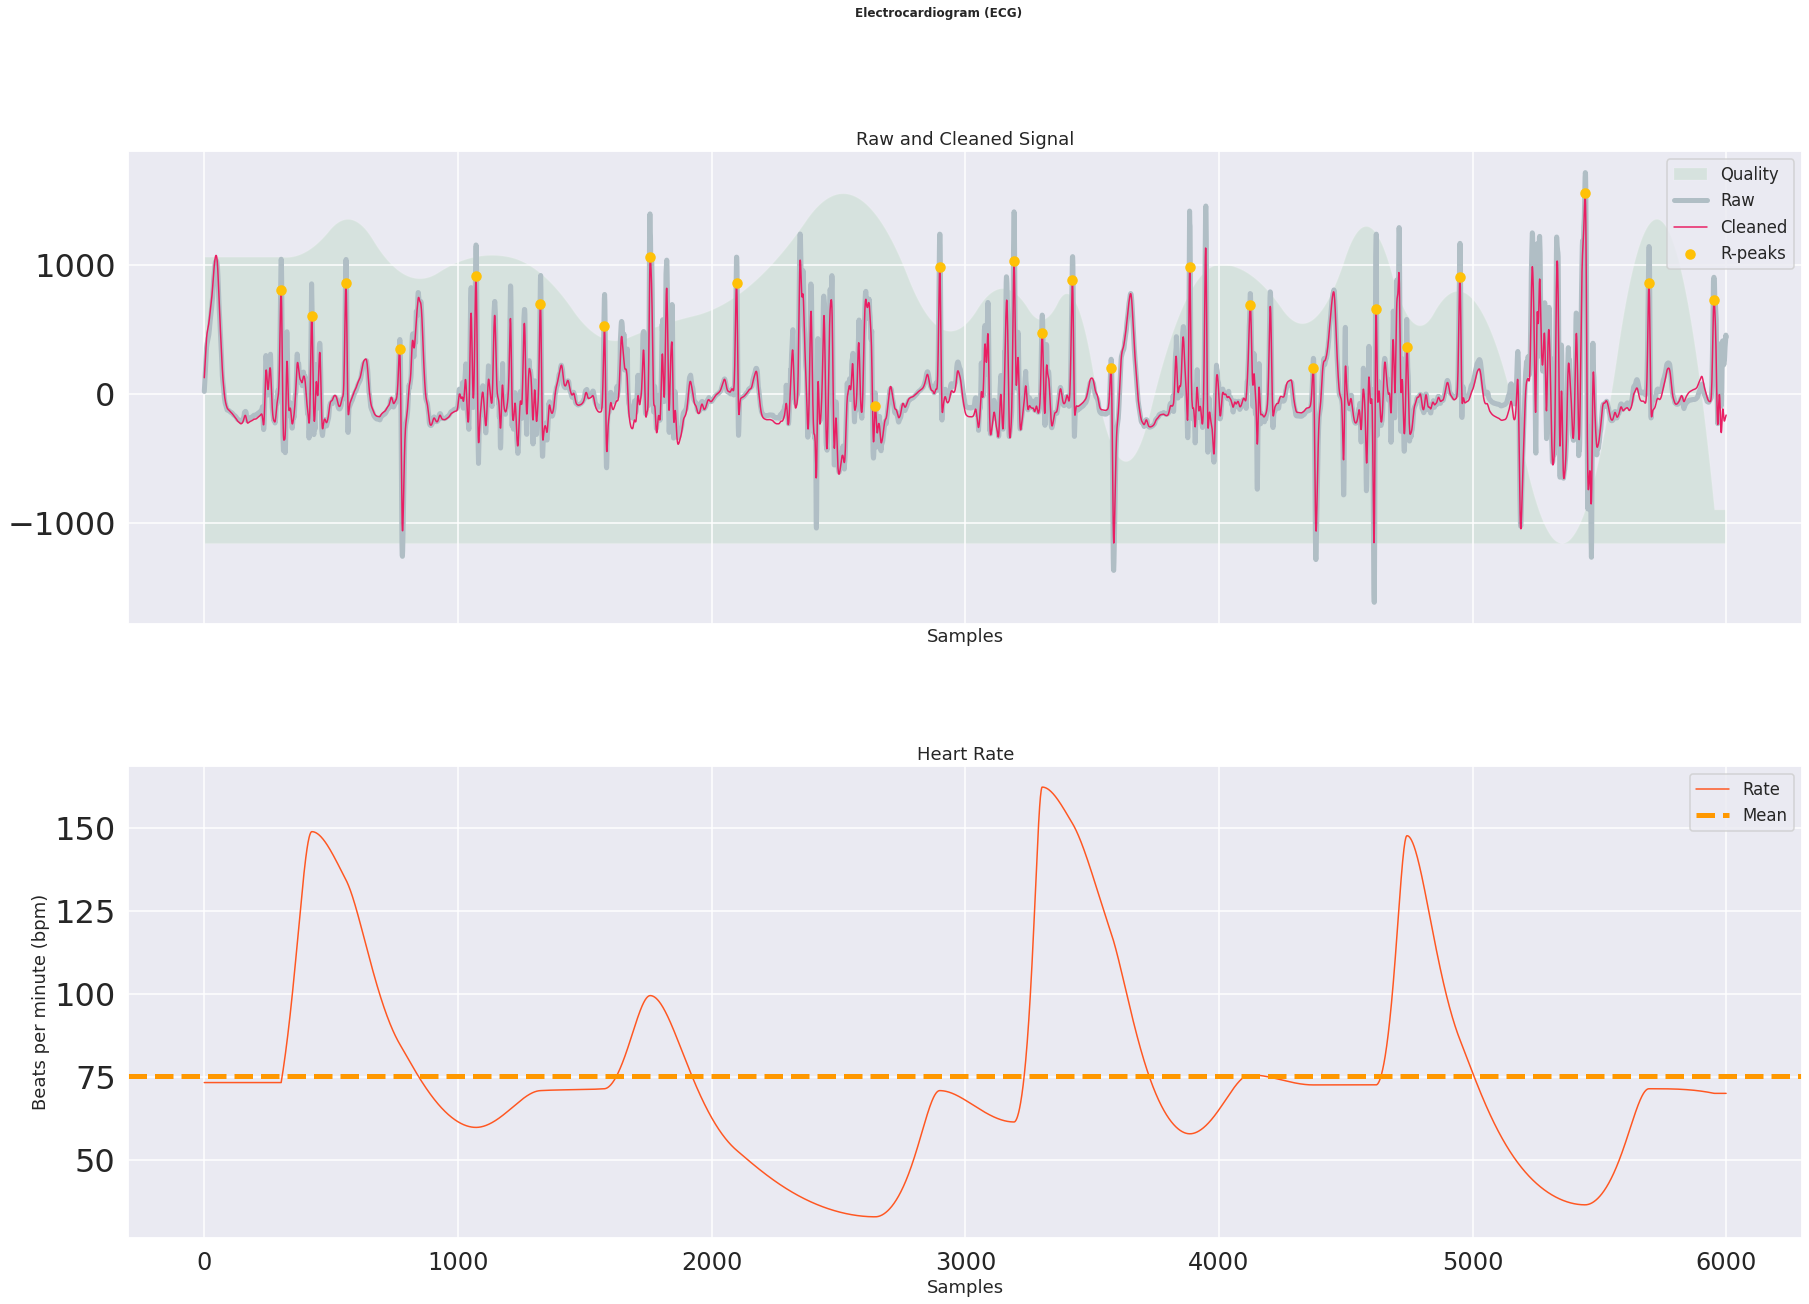

In [23]:
# Default processing pipeline
for class_id in range(num_classes):   
    signal = df_train.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    signal_cut = signal[1000:7000] 
    signals, info = nk.ecg_process(signal_cut, sampling_rate=sr)
    
    # Visualize
    plot = nk.ecg_plot(signals)

### 1.2 Customised preprocessing
- By default Neurokit only takes into account different filtering methods during cleaning stage. There is no detrending (baseline correction) applied. Added below.
- Choose between different detrending and filter methods, details for param choice in
    - https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend and
    - https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
- **Idea**: Only consider samples where "quality" is above a given threshold? 
    - No bad idea, quality close to 1 doesn't necessarily mean good. See Neurokit doc.
    - We should rather add it as a feature
- **Question**: How to find best cleaning method?

In [24]:
## Define customised cleaning function

def my_cleaning(raw_ecg, sampling_rate, detrend_method, filter_method):
    """
    For detrending: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend
    For filtering: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
    """
    if detrend_method == 'constant':
        detrended = nk.signal_detrend(raw_ecg, order=0)
    elif detrend_method == 'linear':
        detrended = nk.signal_detrend(raw_ecg, order=1)
    elif detrend_method == 'quadratic':
        detrended = nk.signal_detrend(raw_ecg, order=2) 
    elif detrend_method == 'cubic':
        detrended = nk.signal_detrend(raw_ecg, order=3)
    elif detrend_method == 'poly10':
        detrended = nk.signal_detrend(raw_ecg, order=10)
    elif detrend_method == 'trav':
        detrended = nk.signal_detrend(raw_ecg, method='tarvainen2002')       
    elif detrend_method == 'loess':
        detrended = nk.signal_detrend(raw_ecg, method='loess')
    elif detrend_method == 'locreg':
        detrended = nk.signal_detrend(raw_ecg, method='locreg',
                                   window=1.5*100, stepsize=0.02*100)
    if filter_method == 'custom_butterworth':
        cleaned = nk.signal_filter(detrended, sampling_rate=sampling_rate, lowcut=2, highcut=9, method='butterworth')
    elif filter_method == 'custom_median': # from paper
        # TODO 
        pass
    else:
        cleaned = nk.ecg_clean(detrended, sampling_rate=sampling_rate, method=filter_method) # cleaning only applies filtering, no detrending
    
    # plot signals
    #plot = nk.signal_plot([raw_ecg, detrended, cleaned])

    return cleaned

# Define a new processing function
def my_processing(ecg_signal, sampling_rate, detrend_method='locreg', \
                  filter_method='neurokit'):
    """
    For detrending: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend
    For filtering: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
    For quality method: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_quality
    
    When using biosppy:
    ecg_rpeaks = ecg.engzee_segmenter(signal_cut, sr)['rpeaks']
    corresponds to
    _, info = my_processing(...)
    info['ECG_R_Peaks']
    
    TODO add quality method
    
    Returns
    * df with raw ecg, clean ecg, ecg heart rate and quality
    * array of samples with rpeaks (same as biosppy) 
    """
    
    # Do processing
    ecg_cleaned = my_cleaning(ecg_signal, sampling_rate=sampling_rate, detrend_method=detrend_method, \
                              filter_method=filter_method)
    
    # instant peaks: df of same length as ecg signal with ones indicating rpeak locations
    # rpeaks: dict with additional information: i.e. samples which include rpeaks (index of few samples with r-peaks)
    # if we use biosppy.signals.ecg.engzee_segmenter 'rpeaks' corresponds to info dict: returns samples with r-peaks (similar locations to nk, not equal)

    instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
    rate = nk.ecg_rate(rpeaks, sampling_rate=sampling_rate, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})

    signals = pd.concat([signals, instant_peaks], axis=1)
    rpeaks = rpeaks['ECG_R_Peaks']
    
    return signals, rpeaks

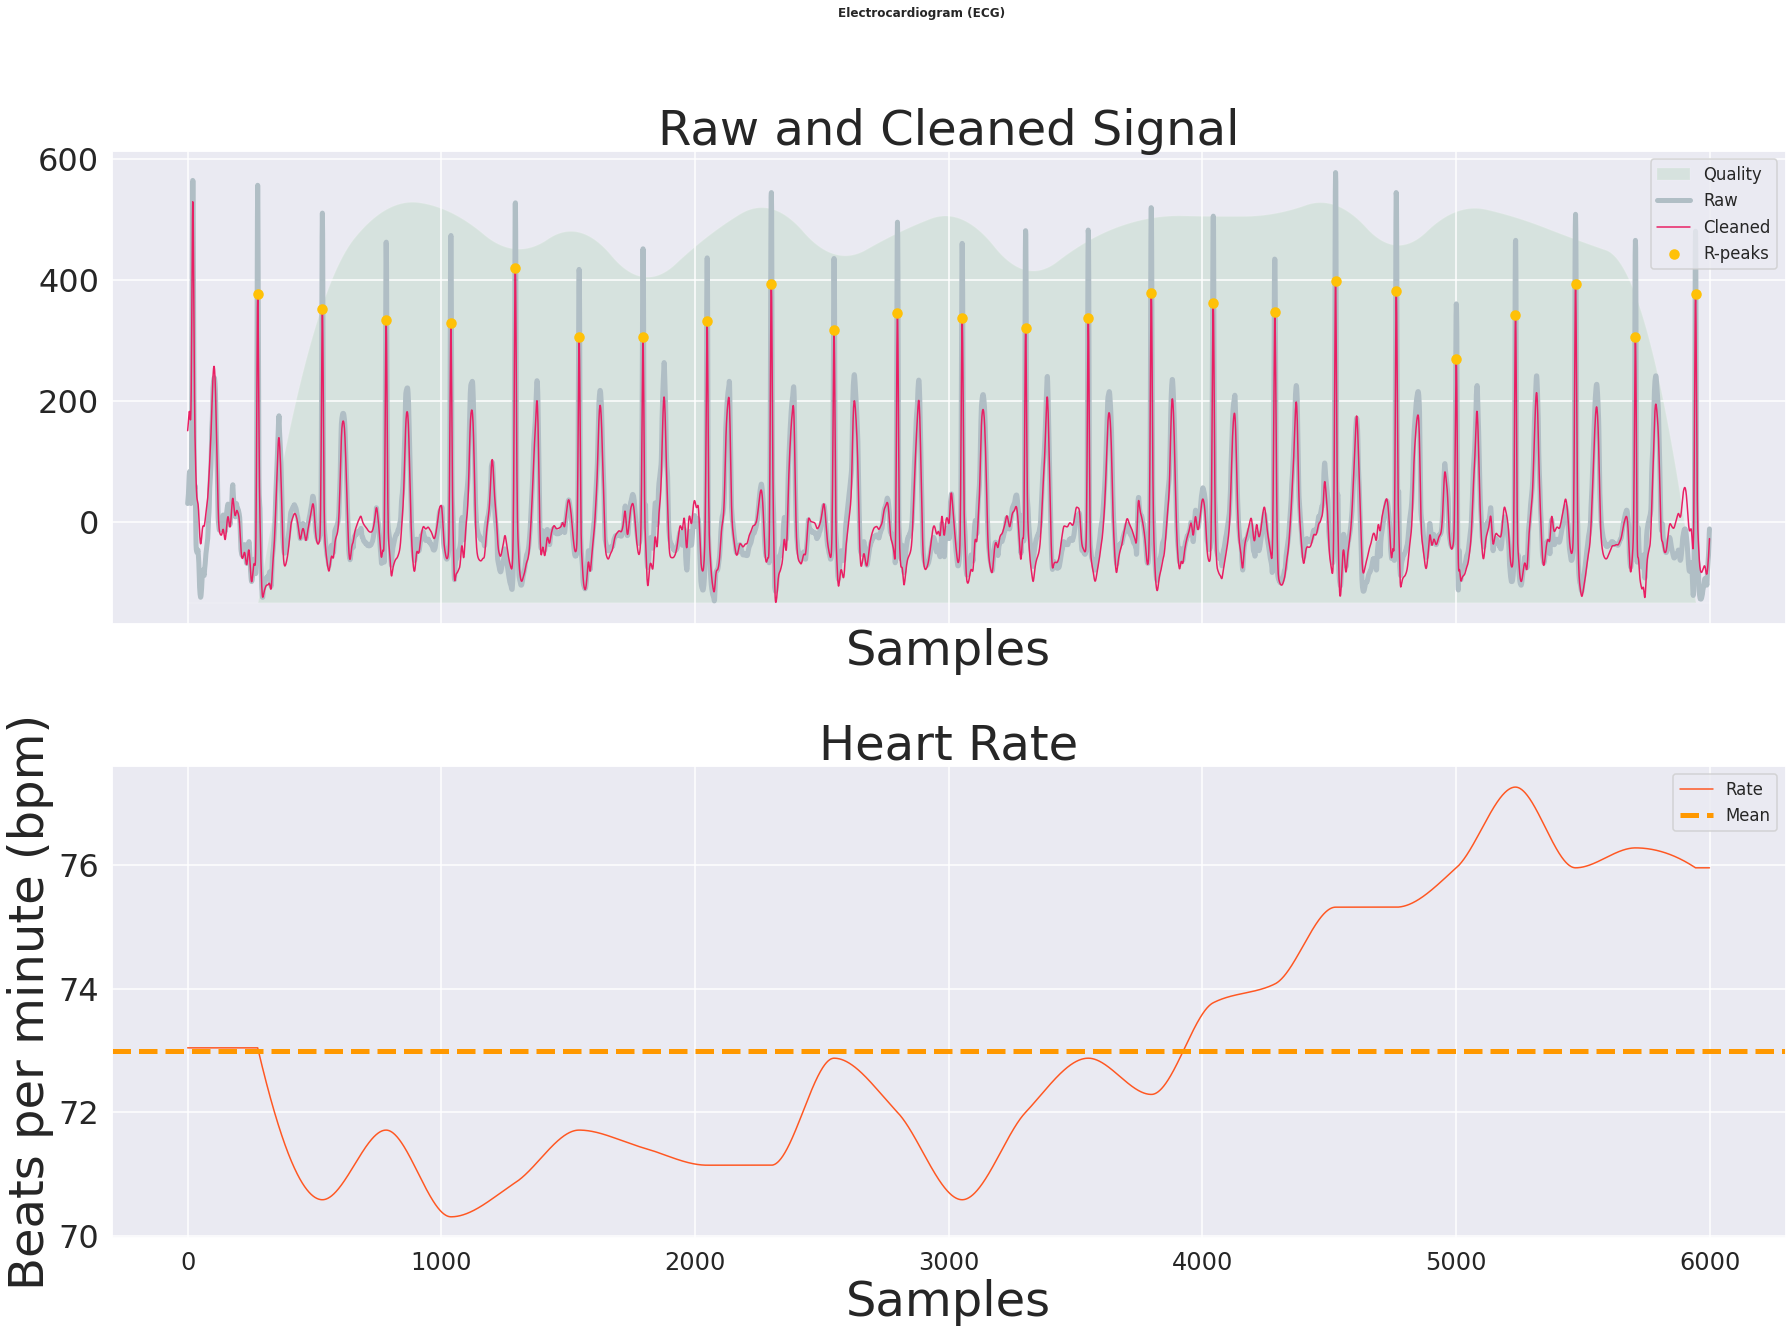

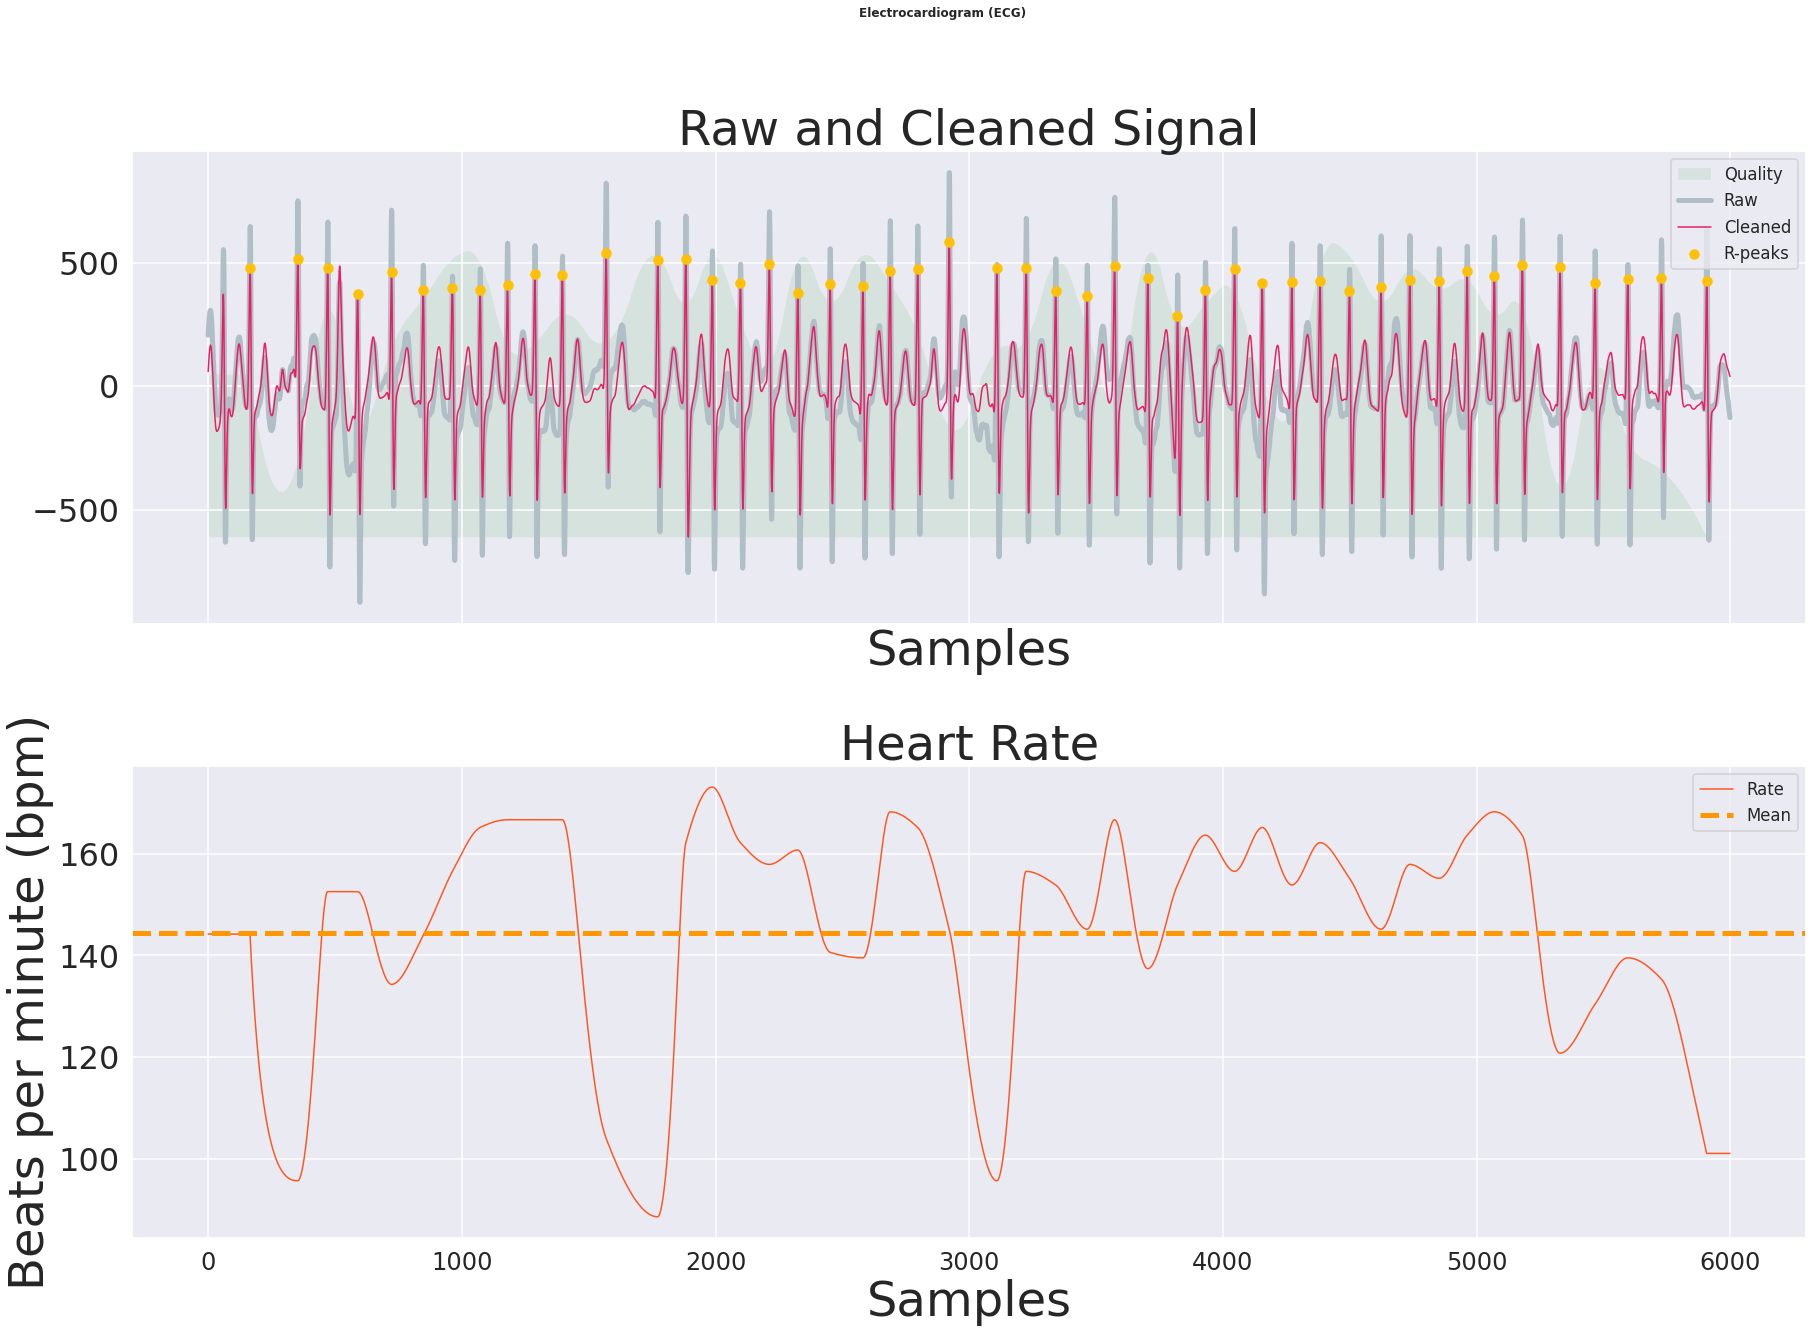

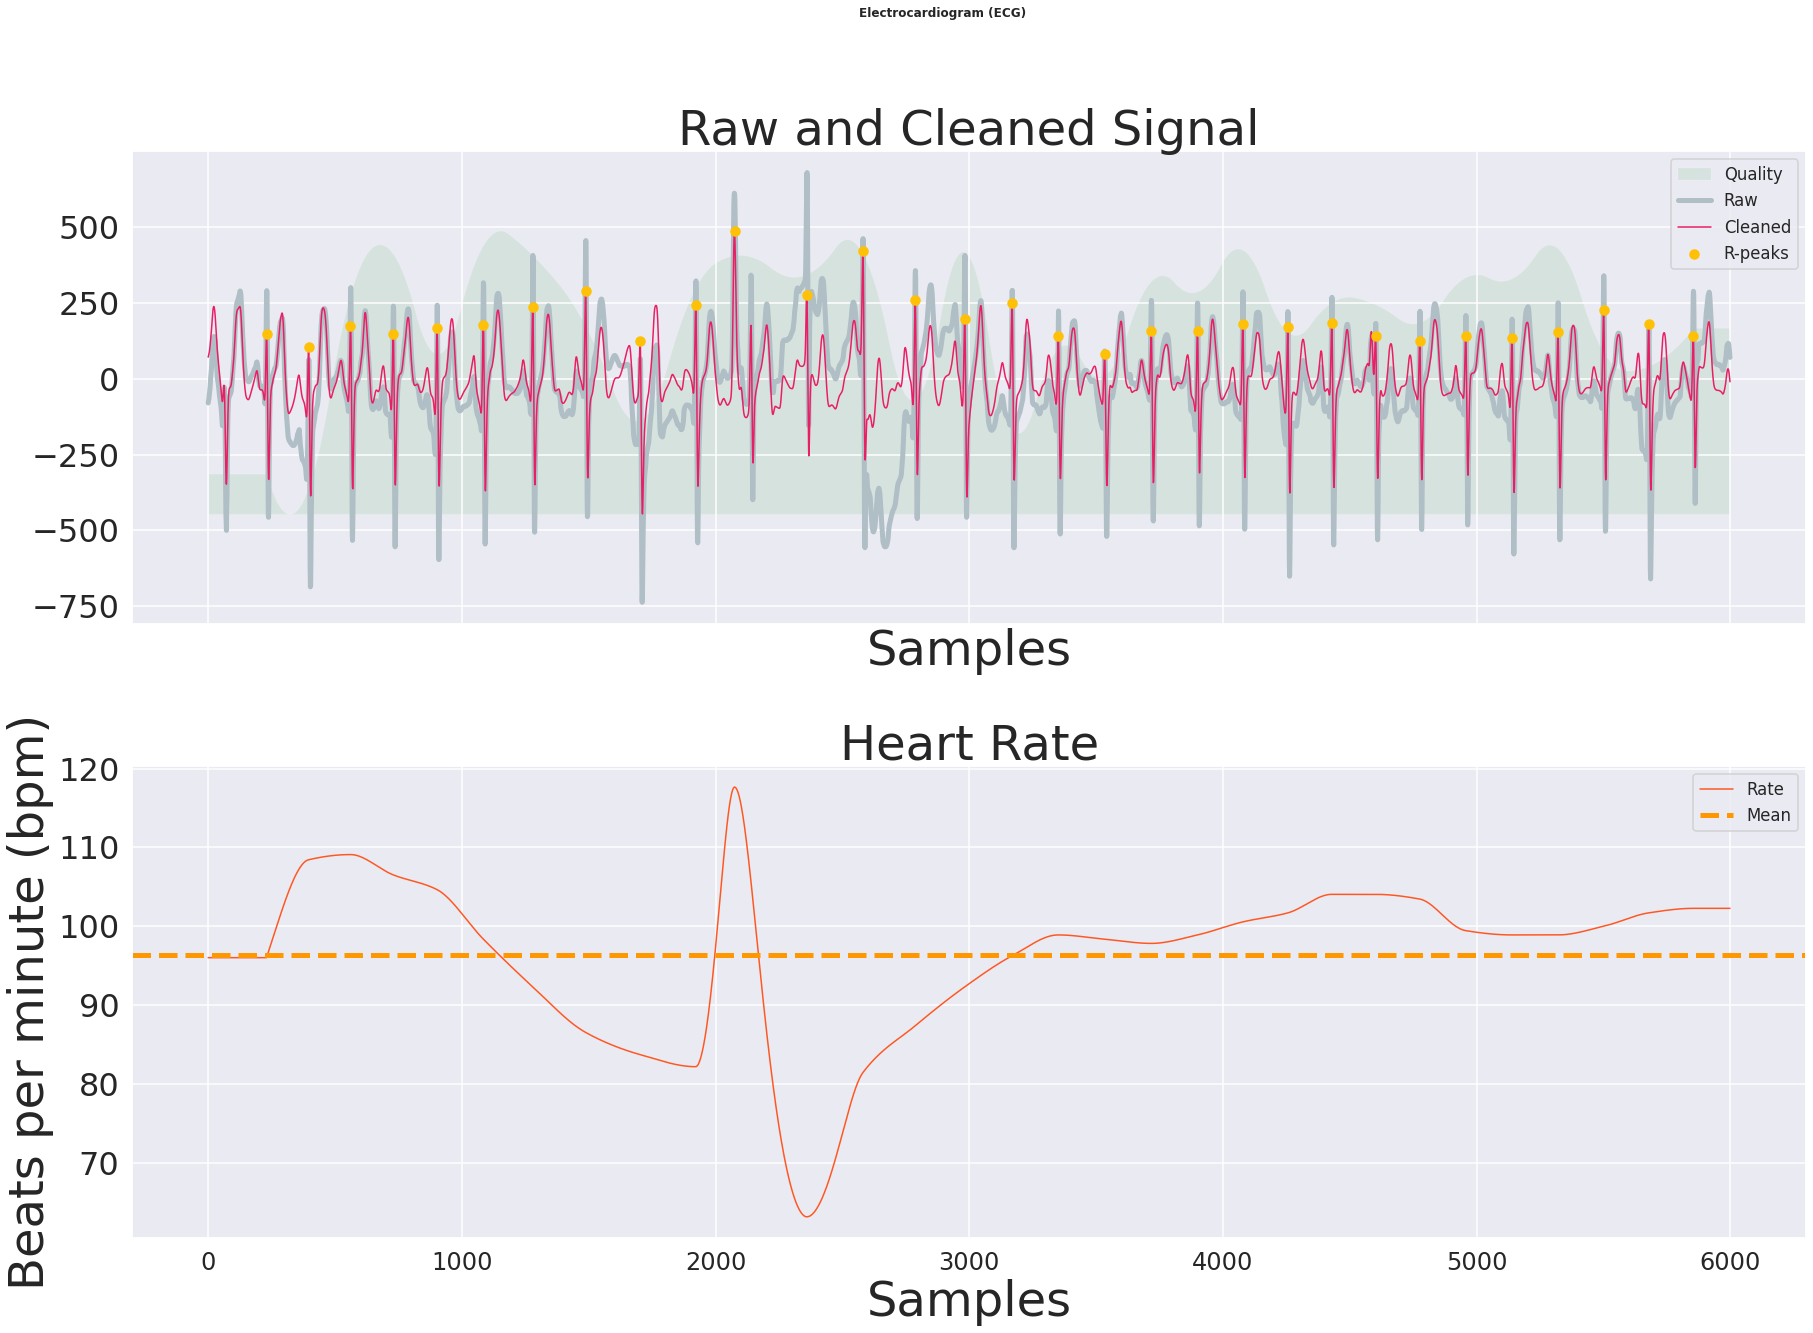

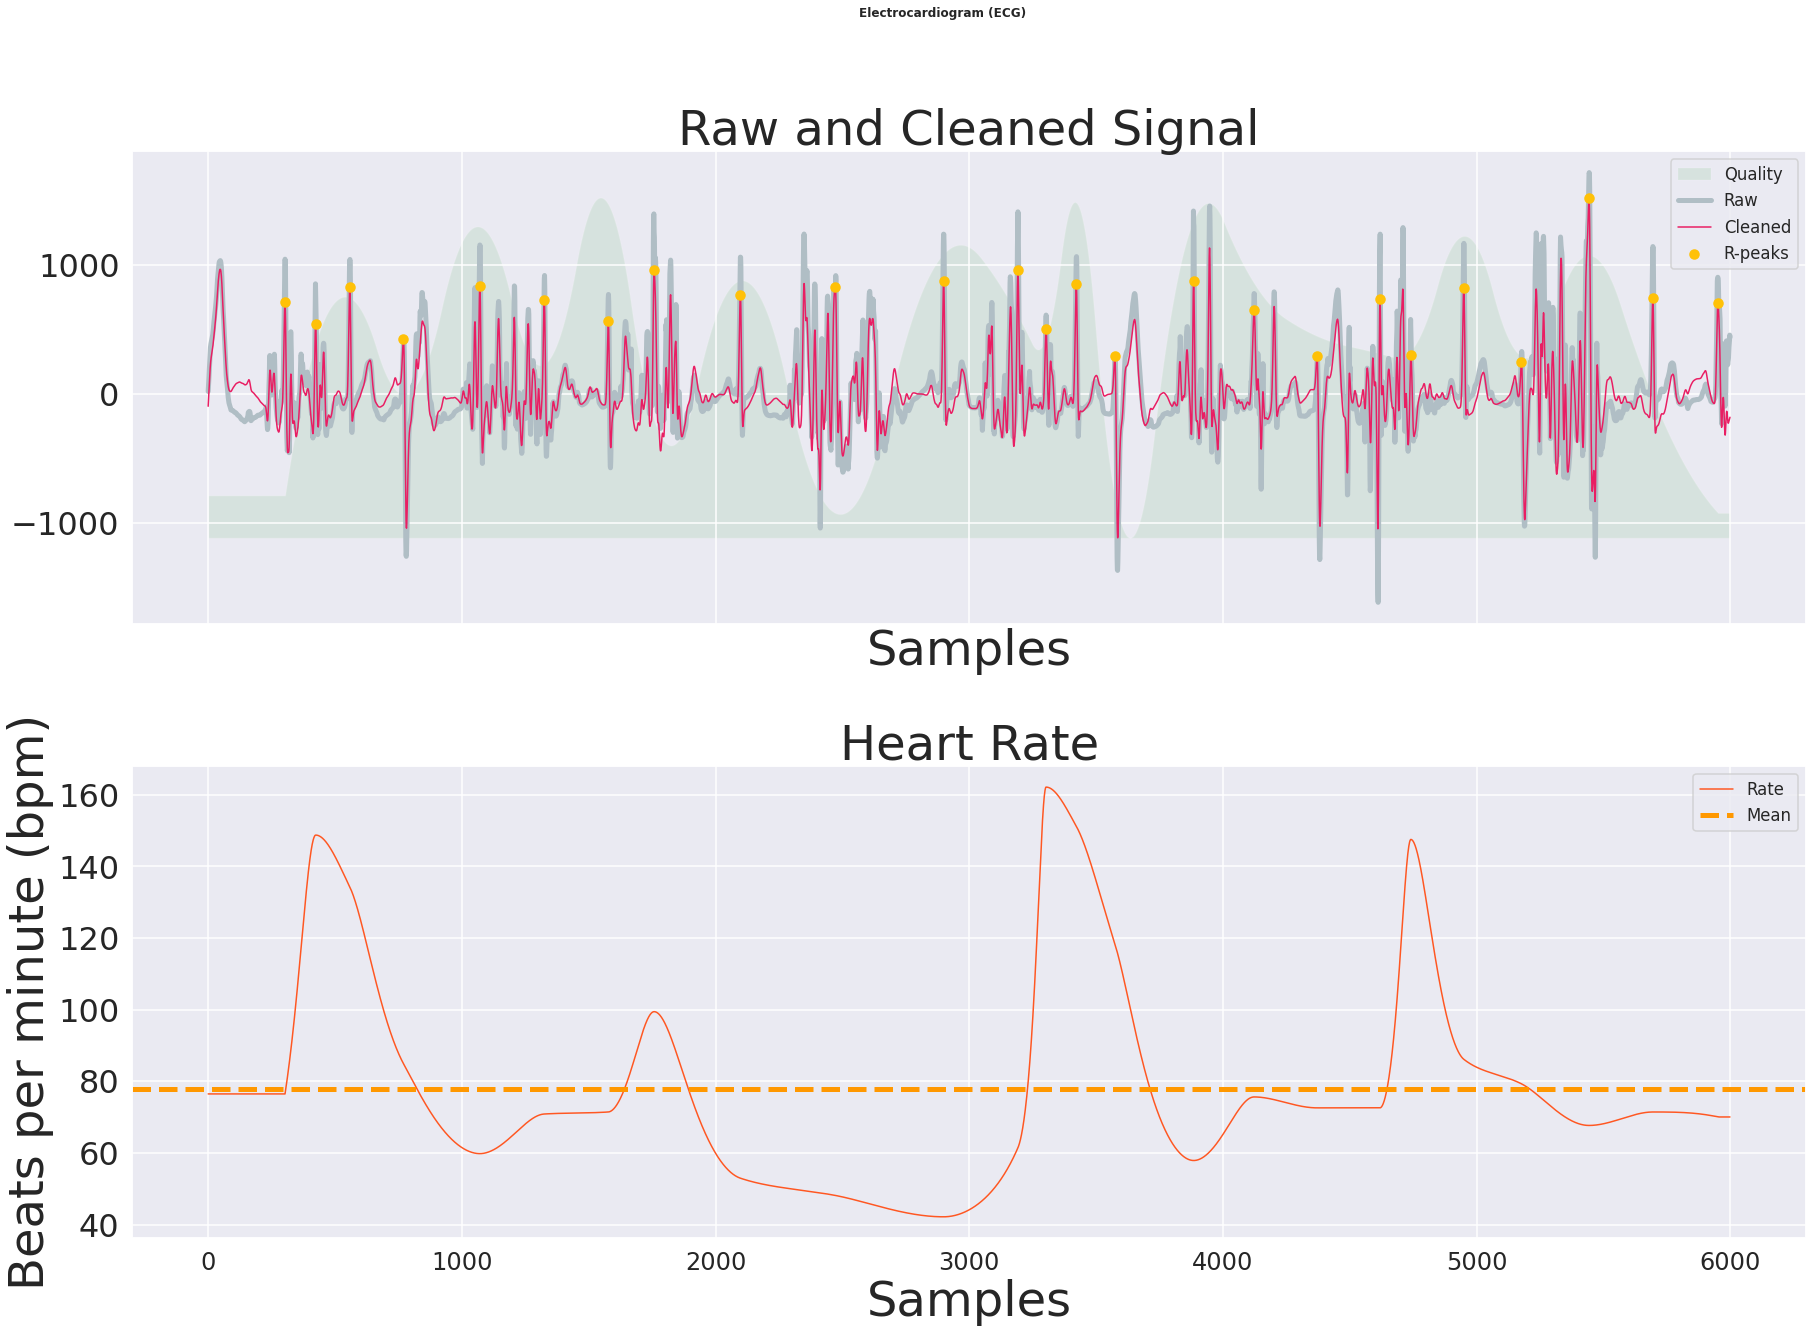

In [27]:
# Repeat for customised preprocessing pipeline
for class_id in range(num_classes):   
    signal = df_train.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    signal_cut = signal[1000:7000] 
    signals, rpeaks = my_processing(signal_cut, sampling_rate=sr, detrend_method='locreg', \
                                  filter_method='neurokit')
    
    
    if len(rpeaks) >= 2:
        signal_clean = signals['ECG_Clean']
        beats = ecg.extract_heartbeats(signal_clean, rpeaks, sr)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)

    # Visualize
    plot = nk.ecg_plot(signals)

---

## 2.0 

### 2.1 How to use templates from extract_heartbeats function (biosppy lib)?
- choose a sample id
- clean using custom cleaning
- extract heartbeats using biosppy
- plot templates (beats) in a 3x3 grid

In [25]:
# dummy example with trimmed sample 0 and custom cleaning function
sample_id = 0
print(f'sample id {sample_id} has class {df_target.loc[sample_id].y}')

# drop ID
X = df_train.drop('id', axis=1)
signal = X.loc[sample_id].dropna().to_numpy(dtype='float32')
signal_cut = signal[1000:12000]
signals, rpeaks = my_processing(signal_cut, sampling_rate=sr, detrend_method='locreg', \
                              filter_method='neurokit')
signal_clean = signals['ECG_Clean']

# extract beat templates
# returns an array of dim num_beats x length of beat, where each beat has the same length regardless of the sample_id
beats = ecg.extract_heartbeats(signal_clean, rpeaks, sr)['templates'] # returns df with templates and rpeak array (don't need rpeak array again?)
print(f'length of beat template is {len(beats[0])} and beats shape is {beats.shape}')
print('each beat has the same length regardless of sample_id, but there might be more or less beats extracted. Cannot use all beats as feature, need to aggregate.')


sample id 0 has class 0
length of beat template is 180 and beats shape is (44, 180)
each beat has the same length regardless of sample_id, but there might be more or less beats extracted. Cannot use all beats as feature, need to aggregate.


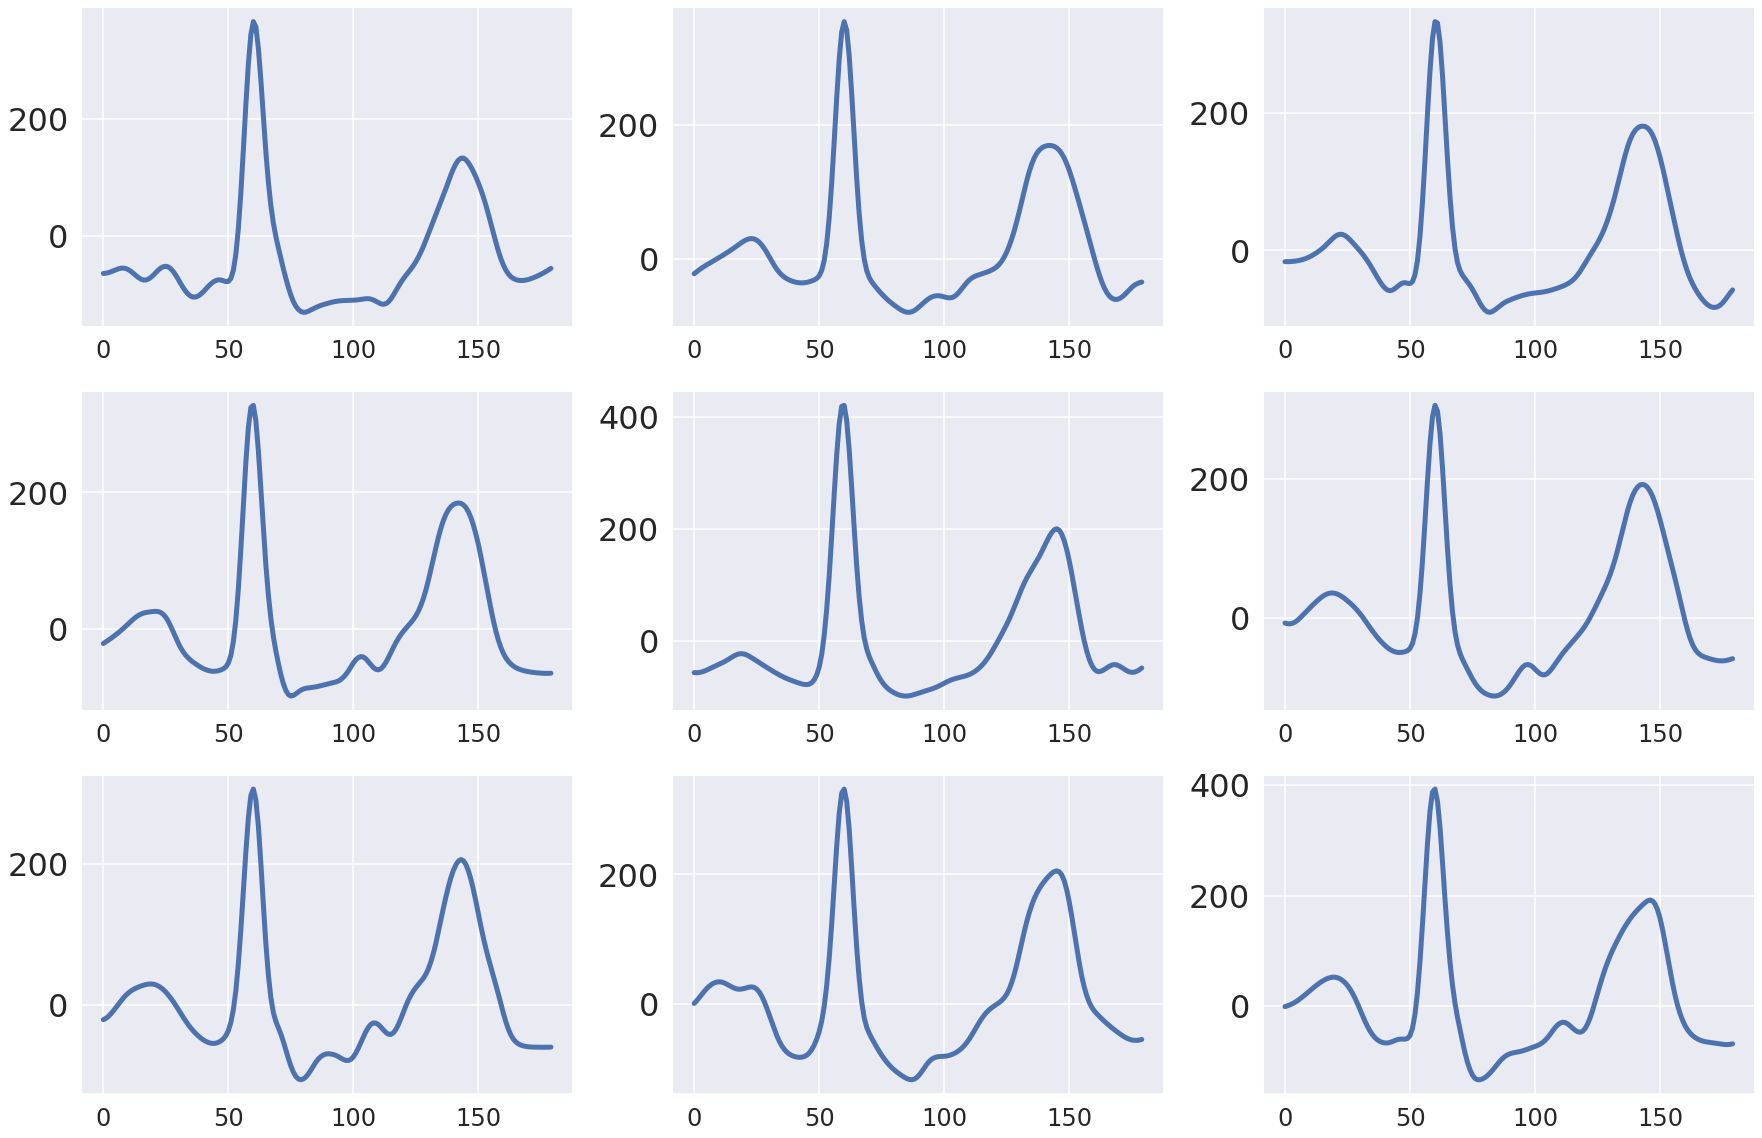

In [31]:
fig, ax = plt.subplots(3,3)
ax[0][0].plot(beats[0])
ax[0][1].plot(beats[1])
ax[0][2].plot(beats[2])
ax[1][0].plot(beats[3])
ax[1][1].plot(beats[4])
ax[1][2].plot(beats[5])
ax[2][0].plot(beats[6])
ax[2][1].plot(beats[7])
ax[2][2].plot(beats[8])

### 2.2. Template-aggregated heartbeat features

In [66]:
mean_beat = np.mean(beats, axis=0)
median_beat = np.median(beats, axis=0)
std_beat = np.std(beats, axis=0)
max_beat = np.max(beats, axis=0)
min_beat = np.min(beats, axis=0)

---

## 3.0 Delineation Features

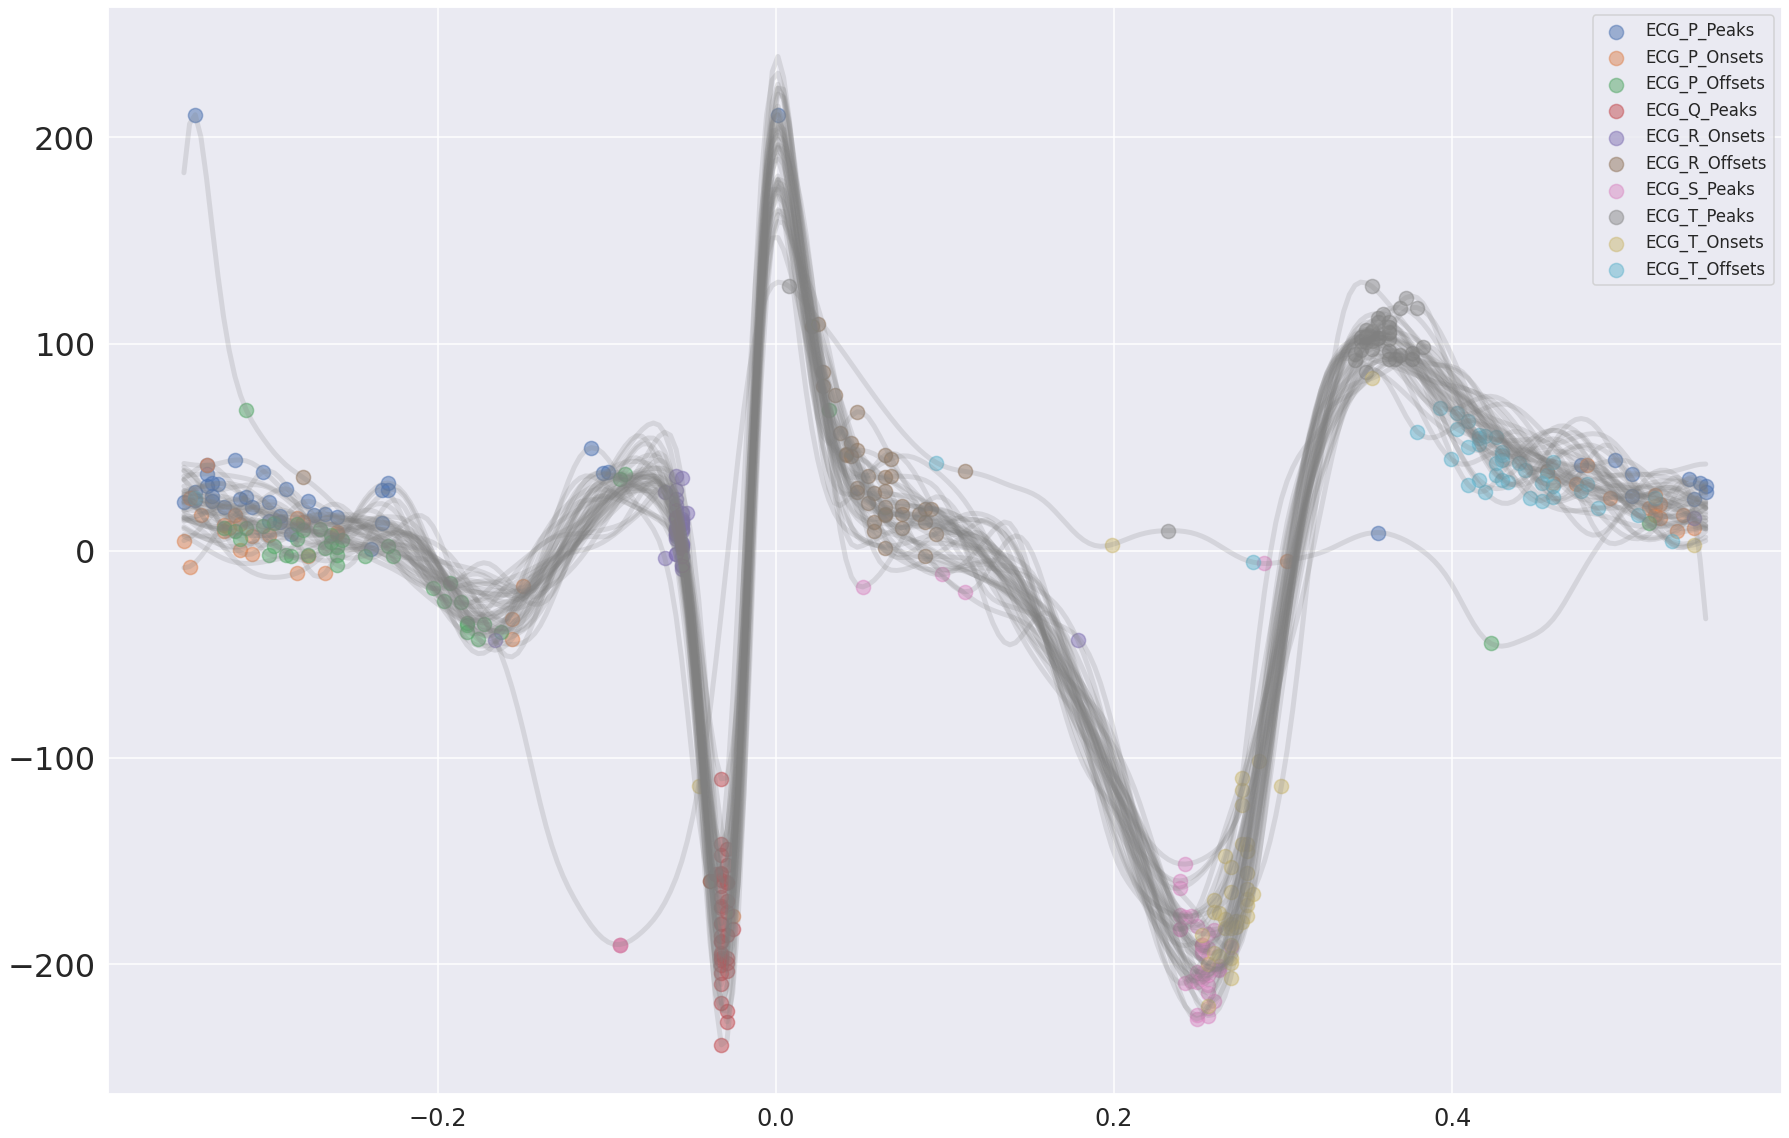

In [11]:
# next to R-peaks, extract P, Q, S and T peaks to get their amplitudes
# use different methods: peak, cwt or dwt
# use wavelet methods to extract QRS on and offsets
_, waves_peak = nk.ecg_delineate(signal_clean, rpeaks, sampling_rate=sr, method="dwt", show=True, show_type='all')

### extract features v0
- stats on amplitudes for each peak
- stats on amplitudes for each onset
- stats on time value for each peak
- stats on time value for each onset (when does P wave start?)

### extract features v1
- aggregate all beat templates (# beats / sample differs): mean, median, std of templates -> aggregated template as a feature in addition


https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/

In [14]:
# remove nans
waves_peak_nonan = {k:[elem for elem in v if elem is not np.nan] for k,v in waves_peak.items()}

In [15]:
# should all have the same shape/length
# corrected for nan values
ppeaks = waves_peak_nonan['ECG_P_Peaks']
qpeaks = waves_peak_nonan['ECG_Q_Peaks']
speaks = waves_peak_nonan['ECG_S_Peaks']
tpeaks = waves_peak_nonan['ECG_T_Peaks']
ponsets = waves_peak_nonan['ECG_P_Onsets']
toffsets = waves_peak_nonan['ECG_T_Offsets']

In [19]:
if len(rpeaks) != len(ppeaks):
    print('Warning, peak lengths R and P are different.')

P_amplitudes = signal_clean[ppeaks]
Q_amplitudes = signal_clean[qpeaks]
S_amplitudes = signal_clean[speaks]
T_amplitudes = signal_clean[tpeaks]
R_amplitudes = signal_clean[rpeaks]
Pon_amplitude = signal_clean[ponsets]
Toff_amplitude = signal_clean[toffsets]

Warning, peak lengths R and P are different.


### 3.1 Amplitude Features

In [21]:
# aggregate amplitude values
mean_P_amplitude = np.mean(P_amplitudes)
mean_Q_amplitude = np.mean(Q_amplitudes)
mean_S_amplitude = np.mean(S_amplitudes)
mean_T_amplitude = np.mean(T_amplitudes)
mean_R_amplitude = np.mean(R_amplitudes)

median_P_amplitude = np.median(P_amplitudes)
median_Q_amplitude = np.median(Q_amplitudes)
median_S_amplitude = np.median(S_amplitudes)
median_T_amplitude = np.median(T_amplitudes)
median_R_amplitude = np.median(R_amplitudes)

std_P_amplitude = np.std(P_amplitudes)
std_Q_amplitude = np.std(Q_amplitudes)
std_S_amplitude = np.std(S_amplitudes)
std_T_amplitude = np.std(T_amplitudes)
std_R_amplitude = np.std(R_amplitudes)

max_P_amplitude = np.max(P_amplitudes)
max_Q_amplitude = np.max(Q_amplitudes)
max_S_amplitude = np.max(S_amplitudes)
max_T_amplitude = np.max(T_amplitudes)
max_R_amplitude = np.max(R_amplitudes)

min_P_amplitude = np.min(P_amplitudes)
min_Q_amplitude = np.min(Q_amplitudes)
min_S_amplitude = np.min(S_amplitudes)
min_T_amplitude = np.min(T_amplitudes)
min_R_amplitude = np.min(R_amplitudes)

#these are amplitudes - useless?
mean_pon = np.mean(Pon_amplitude)
median_pon = np.median(Pon_amplitude)
std_pon = np.std(Pon_amplitude)
max_pon = np.max(Pon_amplitude)
min_pon = np.min(Pon_amplitude)

mean_toff = np.mean(Toff_amplitude)
median_toff = np.median(Toff_amplitude)
std_toff = np.std(Toff_amplitude)
max_toff = np.max(Toff_amplitude)
min_toff = np.min(Toff_amplitude)

### 3.2 Timing Features

In [50]:
# normal rr interval 0.6-1.2s
rr_interval = np.diff(rpeaks)/sr*1000 # rr interval in ms

mean_rr_interval = np.mean(rr_interval)
median_rr_interval = np.median(rr_interval)
std_rr_interval = np.std(rr_interval)
max_rr_interval = np.max(rr_interval)
min_rr_interval = np.min(rr_interval)

# pp interval - corrected for nans
pp_interval = np.diff(ppeaks)/sr*1000 # rr interval in ms

mean_pp_interval = np.mean(pp_interval)
median_pp_interval = np.median(pp_interval)
std_pp_interval = np.std(pp_interval)
max_pp_interval = np.max(pp_interval)
min_pp_interval = np.min(pp_interval)

## TO VERIFY IF THIS REALLY IS QRS DURATION!
# qrs duration r-onset minus r onset
qrs_duration = (np.array(waves_peak['ECG_R_Offsets'])-np.array(waves_peak['ECG_R_Onsets']))/sr*1000 # in ms
qrs_duration = qrs_duration[~np.isnan(qrs_duration)]
assert (qrs_duration>0).all()
qrs_mean = np.mean(qrs_duration)
qrs_median = np.median(qrs_duration)
qrs_std = np.std(qrs_duration)
qrs_max = np.max(qrs_duration)
qrs_min = np.min(qrs_duration)

# normal p wave duration 0.12-0.22s
p_duration = (np.array(waves_peak['ECG_P_Offsets'])-np.array(waves_peak['ECG_P_Onsets']))/sr*1000 # in ms
p_duration = p_duration[~np.isnan(p_duration)]
assert (p_duration>0).all()
p_mean = np.mean(p_duration)
p_median = np.median(p_duration)
p_std = np.std(p_duration)
p_max = np.max(p_duration)
p_min = np.min(p_duration)

# pr segment
pr_duration = (np.array(waves_peak['ECG_R_Onsets'])-np.array(waves_peak['ECG_P_Onsets']))/sr*1000 # in ms
pr_duration = pr_duration[~np.isnan(pr_duration)]
assert (pr_duration>0).all()
pr_mean = np.mean(pr_duration)
pr_median = np.median(pr_duration)
pr_std = np.std(pr_duration)
pr_max = np.max(pr_duration)
pr_min = np.min(pr_duration)

# R time
# time from R onset to R peak, R_onset seems to be the QRS onset: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg_delineate%3E
rwave_peaktime = rpeaks-waves_peak['ECG_R_Onsets']
rwave_peaktime = rwave_peaktime[~np.isnan(rwave_peaktime)]
assert (rwave_peaktime>0).all()
rwave_mean = np.mean(rwave_peaktime)
rwave_median = np.median(rwave_peaktime)
rwave_std = np.std(rwave_peaktime)
rwave_max = np.max(rwave_peaktime)
rwave_min = np.min(rwave_peaktime)

---

## 4.0 HRV Features

In [56]:
# get hrv features  (time, frequency, non-linear)
df_hrv = nk.hrv(rpeaks, sampling_rate=sr)
df_hrv.dropna(axis=1, inplace=True)

/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)


In [57]:
df_hrv

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_pNN50,HRV_pNN20,HRV_HTI,HRV_TINN,HRV_HF,HRV_VHF,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_DFA_alpha1_ExpRange,HRV_DFA_alpha1_ExpMean,HRV_DFA_alpha1_DimRange,HRV_DFA_alpha1_DimMean,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,885.833333,113.904418,126.974435,128.48314,0.128584,0.143339,895.0,76.601,0.085588,94.166667,47.5,80.0,6.666667,625.0,0.078715,0.000579,0.992694,-2.541918,90.851299,126.946769,0.715665,36232.864259,1.397303,5.266073,709.532265,0.4,0.435897,0.588235,0.0,45.784543,47.166343,45.08862,48.717949,0.217017,0.782983,42.372961,80.485551,0.713974,0.286026,107.266173,67.892932,0.545392,0.454608,81.55213,74.455941,0.270536,1.120477,0.323806,1.272049,0.424646,0.381616,0.79493,4.615312,1.0769,1.109007,1.96685,1.910516,1.064386


---

## 5.0 Customised Transformers for Pipeline

In [214]:
#Function or class to extract features from ALL samples
#For each sample:
#1) process (clean and filter)
#2) extract heartbeats from clean signal
#    - 180 timestep features for each  beat variable
#    - mean, median, std,
#3) delineate
#4) extract amplitude features
#5) extract timing features
#6) extract hrv
#7) use in feature union

#1. Preprocessing Transformer
#2. Heartbeat Feature Extractor
#3. Delineation Extractor
#4. HRV Extractor

In [10]:
class MyCleaning(BaseEstimator, TransformerMixin):

    def __init__(self, sampling_rate, detrend_method='locreg', filter_method='neurokit', \
                 trim_beginning=True, downsampling=True):
        
        self.sr = sampling_rate
        self.detrend_method = detrend_method
        self.filter_method = filter_method
        self.order = -1
        self.trim_beginning = trim_beginning
        self.downsampling = downsampling

        if self.detrend_method == 'constant':
            self.order = 0
        elif self.detrend_method == 'linear':
            self.order = 1
        elif self.detrend_method == 'quadratic':
            self.order = 2
        elif self.detrend_method == 'cubic':
            self.order = 3
        elif self.detrend_method == 'poly10':
            self.order = 10
        elif self.detrend_method == 'trav':
            self.detrend_method='tarvainen2002'      
        elif self.detrend_method == 'loess':
            self.detrend_method = 'loess'


    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """np.apply_along_axis is slower than for loop.
        Keeping for loop."""
        
        if self.trim_beginning:
            X = self._trim_beginning(X)
            
        if self.downsampling:
            X = self._downsampling(X)

        clean_signals = []
        for sample in np.arange(X.shape[0]):
            
            if sample % 500 == 0:
                print(f'cleaning sample {sample}')
            # drop nans
            sample_nonan = X.iloc[sample].dropna().to_numpy(dtype='float32')
            clean = self._cleaning(sample_nonan)
            
            # pad array with nan to match previous dimensions
            pad_width = X.iloc[sample].shape[0]-clean.shape[0]
            cleaned_padded = np.pad(clean, pad_width=(0, pad_width), mode='constant', constant_values=np.nan)           
            clean_signals.append(cleaned_padded)
            
        return np.stack(clean_signals)
    
    def _trim_beginning(self, X, skip_num_samples=540):
        """Trim signal at begining and skip n first samples given by skip_num_samples.
        Applied before downsampling if downsampling=True.
        By default skips ~3 heartbeats, i.e. 3x180 samples, where 180 corresponds to the heartbeat extraction
        sample size"""
        
        X_trimmed = X[X.columns[skip_num_samples:]]
        
        return X_trimmed
    
    def _downsampling(self, X, sampling_divisor=2):
        """Selects every n-th (sampling_divisor) timestep.
        By default cuts sampling rate into two."""
        
        X_downsampled = X[X.columns[::sampling_divisor]]
        
        return X_downsampled
    
    def _cleaning(self, raw_ecg):
        """
        For detrending: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend
        For filtering: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
        """

        detrended = nk.signal_detrend(raw_ecg, order=self.order, method=self.detrend_method, \
                                      window=1.5*100, stepsize=0.02*100)        

        if self.filter_method == 'custom_butterworth':
            cleaned = nk.signal_filter(detrended, sampling_rate=self.sr, lowcut=2, highcut=9, method='butterworth')
        else:
             # ecg_clean only applies filtering, no detrending
            cleaned = nk.ecg_clean(detrended, sampling_rate=self.sr, method=self.filter_method)

        return cleaned

In [11]:
cleaner = MyCleaning(sampling_rate=sr, downsampling=False, trim_beginning=False)

In [12]:
data = df_train.drop('id', axis=1)

In [13]:
t = data[:5]

In [14]:
t.shape

(5, 17842)

In [15]:
t

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178,x179,x180,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199,x200,x201,x202,x203,x204,x205,x206,x207,x208,x209,x210,x211,x212,x213,x214,x215,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225,x226,x227,x228,x229,x230,x231,x232,x233,x234,x235,x236,x237,x238,x239,x240,x241,x242,x243,x244,x245,x246,x247,x248,x249,...,x17592,x17593,x17594,x17595,x17596,x17597,x17598,x17599,x17600,x17601,x17602,x17603,x17604,x17605,x17606,x17607,x17608,x17609,x17610,x17611,x17612,x17613,x17614,x17615,x17616,x17617,x17618,x17619,x17620,x17621,x17622,x17623,x17624,x17625,x17626,x17627,x17628,x17629,x17630,x17631,x17632,x17633,x17634,x17635,x17636,x17637,x17638,x17639,x17640,x17641,x17642,x17643,x17644,x17645,x17646,x17647,x17648,x17649,x17650,x17651,x17652,x17653,x17654,x17655,x17656,x17657,x17658,x17659,x17660,x17661,x17662,x17663,x17664,x17665,x17666,x17667,x17668,x17669,x17670,x17671,x17672,x17673,x17674,x17675,x17676,x17677,x17678,x17679,x17680,x17681,x17682,x17683,x17684,x17685,x17686,x17687,x17688,x17689,x17690,x17691,x17692,x17693,x17694,x17695,x17696,x17697,x17698,x17699,x17700,x17701,x17702,x17703,x17704,x17705,x17706,x17707,x17708,x17709,x17710,x17711,x17712,x17713,x17714,x17715,x17716,x17717,x17718,x17719,x17720,x17721,x17722,x17723,x17724,x17725,x17726,x17727,x17728,x17729,x17730,x17731,x17732,x17733,x17734,x17735,x17736,x17737,x17738,x17739,x17740,x17741,x17742,x17743,x17744,x17745,x17746,x17747,x17748,x17749,x17750,x17751,x17752,x17753,x17754,x17755,x17756,x17757,x17758,x17759,x17760,x17761,x17762,x17763,x17764,x17765,x17766,x17767,x17768,x17769,x17770,x17771,x17772,x17773,x17774,x17775,x17776,x17777,x17778,x17779,x17780,x17781,x17782,x17783,x17784,x17785,x17786,x17787,x17788,x17789,x17790,x17791,x17792,x17793,x17794,x17795,x17796,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806,x17807,x17808,x17809,x17810,x17811,x17812,x17813,x17814,x17815,x17816,x17817,x17818,x17819,x17820,x17821,x17822,x17823,x17824,x17825,x17826,x17827,x17828,x17829,x17830,x17831,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,-70,-51,-21,34,112,227,360,450,481,452,362,228,108,25,-1,-8,-12,-14,-17,-21,-28,-35,-42,-50,-57,-67,-76,-80,-81,-82,-82,-82,-82,-82,-83,-84,-84,-83,-79,-74,-70,-66,-62,-59,-55,-51,-47,-43,-41,-39,-37,-36,-34,-33,-32,-30,-29,-26,-23,-20,-16,-13,-9,-6,-4,0,2,6,12,23,35,48,59,68,76,85,94,102,109,115,122,129,135,142,150,162,180,192,204,215,225,233,239,242,242,235,225,208,187,168,147,125,98,73,54,39,27,19,11,3,-3,-7,-9,-12,-14,-17,-19,-22,-24,-26,-28,-30,-32,-34,-35,-36,-39,-45,-51,-51,-46,-39,-30,-20,-16,-14,-14,-13,-12,-11,-10,-9,-9,-8,-7,-6,-5,-4,-3,-2,0,3,12,29,52,88,135,189,243,296,334,348,353,349,340,331,322,312,300,266,203,138,88,51,13,-3,-10,-13,-16,-17,-18,-17,-15,-11,-6,-1,5,15,22,28,33,37,40,41,37,29,20,13,6,0,-4,-7,-6,-3,2,9,22,45,68,93,121,149,174,189,192,193,195,196,196,196,195,192,187,181,170,149,129,106,77,51,14,-27,-49,-63,-72,-80,-88,-97,-105,-113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [446]:
%%time
new = cleaner.fit_transform(data)

cleaning sample 0
cleaning sample 500
cleaning sample 1000
cleaning sample 1500
cleaning sample 2000
cleaning sample 2500
cleaning sample 3000
cleaning sample 3500
cleaning sample 4000
cleaning sample 4500
cleaning sample 5000
CPU times: user 18min 39s, sys: 1.53 s, total: 18min 40s
Wall time: 18min 39s


In [16]:
newt = cleaner.fit_transform(t)

cleaning sample 0


In [19]:
newt

array([[ 200.60137713,  195.48581776,  190.20252976, ...,           nan,
                  nan,           nan],
       [ -19.98687357,  -20.87789467,  -21.64551792, ...,           nan,
                  nan,           nan],
       [ -12.47273875,   -9.34892466,   -6.48538893, ...,           nan,
                  nan,           nan],
       [   2.9977984 , -126.58701667, -237.51248482, ...,           nan,
                  nan,           nan],
       [   3.04202448,    1.23242219,   -0.5007058 , ...,           nan,
                  nan,           nan]])

In [235]:
class MyHeartBeatExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate):
        self.sr = sampling_rate
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        mean_beats = []
        median_beats = []
        std_beats = []
        max_beats = []
        min_beats = []
        rates = []
        
        #features = np.apply_along_axis(self.cleaning, 1, X)
        #_, rpeaks = np.apply_along_axis(self._get_rpeaks(sample_clean)

        for id_clean in np.arange(X.shape[0]):
            if id_clean % 500 == 0:
                print(f'extracting features from sample {id_clean}')
            sample_clean = X[id_clean]

            # get rpeaks
            _, rpeaks = self._get_rpeaks(sample_clean)
            
            # get heartrate as a feature
            rate = self._get_heartrate(rpeaks, sample_clean)
            rates.append(rate)
            
            print(sample_clean)
            # get template for a single sample and aggregate over heartbeats for that single sample
            beats = ecg.extract_heartbeats(sample_clean, rpeaks, self.sr)['templates']
            
            # aggregate over heartbeats
            mean_beat = np.mean(beats, axis=0) # shape (num beats x standard length per beat)
            median_beat = np.median(beats, axis=0)
            std_beat = np.std(beats, axis=0)
            max_beat = np.max(beats, axis=0)
            min_beat = np.min(beats, axis=0)
            
            mean_beats.append(mean_beat)
            median_beats.append(median_beat)
            std_beats.append(std_beat)
            max_beats.append(max_beat)
            min_beats.append(min_beat)
        
        features = [rates, mean_beats, median_beats, std_beats, max_beats, min_beats]
        # should return X_new (num_samples, num_features)
        return np.stack(features)

    def _get_rpeaks(self, ecg_cleaned):

        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=self.sr)
        return instant_peaks, rpeaks
    
    def _get_heartrate(self, rpeaks, ecg_cleaned):
        rate = nk.ecg_rate(rpeaks, sampling_rate=self.sr, desired_length=len(ecg_cleaned))
        return rate
    
    def _get_features_from_sample(self, ecg_cleaned):
        """Returns a list of aggregated heartbeat features for each sample"""
        
        ecg_nonans = ecg_cleaned[~np.isnan(cg_cleaned)]
        _, rpeaks = self._get_rpeaks(ecg_nonans)
        heartrates = self._get_heartrate(rpeaks, ecg_nonans)
        beats = ecg.extract_heartbeats(ecg_nonans, rpeaks, self.sr)['templates']

        # aggregate over heartbeats
        mean_beat = np.mean(beats, axis=0) # shape (num beats x standard length per beat)
        median_beat = np.median(beats, axis=0)
        std_beat = np.std(beats, axis=0)
        max_beat = np.max(beats, axis=0)
        min_beat = np.min(beats, axis=0)
        
        sample_features = [heartrates, mean_beat, median_beat, std_beat, max_beat, min_beat]
        
        return sample_features

In [236]:
MyExtractor = MyHeartBeatExtractor(sampling_rate=sr)

In [241]:
data_clean = cleaner.fit_transform(signal)

cleaning sample 0


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [237]:
features = MyExtractor.fit_transform(signal_clean)

extracting features from sample 0
0        200.601377
1        195.485818
2        190.202530
3        184.762263
4        179.411647
            ...    
16274    -28.738350
16275    -23.297347
16276    -17.126309
16277    -10.425120
16278     -3.404237
Name: 0, Length: 16279, dtype: float64


AxisError: axis -1 is out of bounds for array of dimension 0

In [ ]:
class MyDelineationExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate, delineation_method):
        self.sr = sampling_rate
        self.delineation_method = delineation_method
           
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return 
    
    
    def _get_wavepeaks(self, ecg_cleaned):
        ecg_nonans = ecg_cleaned[~np.isnan(ecg_cleaned)]
        
        _, waves_peak = nk.ecg_delineate(signal_clean, rpeaks, sampling_rate=self.sr, \
                                         method=self.delineation_method, show=False, show_type='all')
        waves_peak_nonan = {k:[elem for elem in v if elem is not np.nan] for k,v in waves_peak.items()}
        
        
        # should all have the same shape/length
        # corrected for nan values
        ppeaks = waves_peak_nonan['ECG_P_Peaks']
        qpeaks = waves_peak_nonan['ECG_Q_Peaks']
        speaks = waves_peak_nonan['ECG_S_Peaks']
        tpeaks = waves_peak_nonan['ECG_T_Peaks']
        ponsets = waves_peak_nonan['ECG_P_Onsets']
        toffsets = waves_peak_nonan['ECG_T_Offsets']
        
        
        
        

In [472]:
class MyHRVExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate):
        self.sr = sampling_rate    
    
    def _get_hrv(self, ecg_cleaned):
        
        ecg_nonans = ecg_cleaned[~np.isnan(ecg_cleaned)]
        _, rpeaks = nk.ecg_peaks(ecg_nonans, sampling_rate=self.sr)
        
        df_hrv = nk.hrv(rpeaks, sampling_rate=self.sr)
        df_hrv.dropna(axis=1, inplace=True)
        
        return df_hrv.values
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        hrvs = []
        for id_clean in np.arange(X.shape[0]):
            if id_clean % 500 == 0:
                print(f'extracting features from sample {id_clean}')
            
            sample_clean = X[id_clean]
            
            hrv = self._get_hrv(sample_clean)
            print(hrv)
            hrvs.append(hrv)  
        print(hrvs)
        return np.stack(hrvs)

In [473]:
myhrv = MyHRVExtractor(sampling_rate=sr)

In [470]:
newt.shape

(3, 17842)

In [474]:
hrvt = myhrv.transform(newt)

extracting features from sample 0
[[ 8.15846154e+02  6.58966751e+01  6.42099421e+01  6.42237601e+01
   8.07709577e-02  7.87034931e-02  8.30000000e+02  1.48260000e+01
   1.78626506e-02  2.33333333e+01  1.53846154e+00  4.61538462e+00
   3.82352941e+00  5.23437500e+02  8.42798962e-03  4.72863509e-03
   3.66993195e-04  1.78233031e+00  6.23205246e-01  3.49657549e-01
  -5.35411868e+00  4.54130563e+01  5.33531709e+01  8.51178205e-01
   7.61186082e+03  1.17484211e+00  4.58846095e+00  2.50726208e+02
   6.61538462e-01  6.66666667e-01  9.21052632e-01  2.35294118e-01
   7.45161290e+01  7.81461667e+01  7.15973068e+01  4.91228070e+01
   9.87409466e-01  1.25905339e-02  4.54732125e+01  5.13486543e+00
   8.48544958e-01  1.51455042e-01  4.91470737e+01  2.07635737e+01
   9.07403999e-01  9.25960011e-02  4.73457913e+01  1.51243650e+01
   1.38856713e+00  2.50664381e-01  1.47977805e+00  7.85644436e-01
   8.72464205e-01  5.26582569e-01  4.29562660e-01  4.13209056e+00
   3.83726197e-01  4.04225380e-01  1.71061

/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 32 (the max).
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitW

[[ 7.89047619e+02  5.23036098e+01  5.52090501e+01  5.60321506e+01
   6.62870131e-02  6.99692247e-02  8.00000000e+02  4.44780000e+01
   5.55975000e-02  6.33333333e+01  8.57142857e+00  6.85714286e+01
   8.75000000e+00  2.26562500e+02  2.49891762e-02  1.07598368e-02
   6.99017235e-01 -3.68931250e+00  3.96207137e+01  6.31420086e+01
   6.27485798e-01  7.85942112e+03  1.59366157e+00  4.60236067e+00
   4.02507969e+02  4.57142857e-01  5.00000000e-01  6.47058824e-01
   0.00000000e+00  5.12195122e+01  5.10063238e+01  5.14160567e+01
   5.00000000e+01  6.07162003e-01  3.92837997e-01  3.08766417e+01
   2.48361635e+01  4.61691362e-01  5.38308638e-01  4.29036526e+01
   4.63269882e+01  5.02795115e-01  4.97204885e-01  3.73770679e+01
   3.71687023e+01  9.22860636e-01  8.99425942e-01  8.47867070e-01
   1.56924151e+00  5.24370730e-01  3.24364763e-01  1.15267951e+00
   4.65057195e+00  1.14466925e+00  1.20722155e+00  1.71630304e+00
   1.93728770e+00  1.17240755e+00]]
[[ 9.00689655e+02  3.59163414e+01  2.653

/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)


ValueError: all input arrays must have the same shape